In [7]:
from itertools import cycle

# Math
import numpy as np
import pandas as pd

# Bio
from Bio import motifs, SeqIO
from Bio.Align import Applications
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# custom
import unidip.unidip.unidip as unidip
from util import *

import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")

In [72]:
muscle_exe = r"./muscle3.8.31_i86linux64"
in_file = r"./generated.fasta"
out_file = r"./generatedaligned.fasta"

In [73]:
muscle_cline = Applications.MuscleCommandline(muscle_exe, input=in_file, out=out_file)
muscle_cline()
print(muscle_cline)

In [70]:
# mis-aligned
strings = genMutStrs(pattern="ACTGTGCACGTGACG", mut_num=6, insert_num=1, noise_len=100, noise_var=3, number=100)
strings = [s[:215] for s in strings]
seqs = [SeqRecord(Seq(s[:215]), id=f"Seq{i}", description="Generated Sequence") for i, s in zip(range(len(strings)), strings)]
# motif = motifs.create(strings)

In [71]:
SeqIO.write(seqs, 'generated.fasta', 'fasta')

100

In [2]:
alignedSeqs = list(SeqIO.parse("aligned.fasta", "fasta"))

In [84]:
[str(s.seq) for s in alignedSeqs[:10]]

['----------------------TAGCATGAGTTGTCATCTTTTCTCAAAAAAATGAAGAGATGGAAAAGATCTCCACGCAAGAACTTCCGC---------------------------------------ATAAACTCCATGACATCCCGCCTGTGCTTATGATCCTGCGCAAGTGAAGGGAGTACT---CAAGAACGCCACATTCAGACGGATCTTATT----TGAACGCCTTGACGGAAGGTCTAATCAGGTCCTGCTGGGTACTAACGAACGCCAATTAG------------------------------',
 '---------------------------------CGCCGTGCTTAGAGCGTTGGCTGATGAATACTGGTGACTCGCTCGGTAAGGATAGGTA-------------------------AAAAGGATGTAGGCGTACGGCTGTCTTTGGTAAAACCATAGACGGTCAGTGCAACTGACAGATAGCATGAC---ACCGGTCTGCGCGCGCATCCAGACCCGTTCTTC-TGGGCTAGCTCACTTATATTGAACCGTATTTGTAAAGACTGTGTTTAATTAAT------------------------------------',
 '--------------------------------------TACGGATTTGAATTCGTACTCTGTCAGGCAGCCAACAAAGAATAGAGTAATCT------------------ATCGGATCGACCTCAATAGCTACTCTTCGAAGCGCGTGTCATTCTTCGACAGGGTTCTTGACGAATGCCA--------------TAACTTTTTGTTTCATACTTCTTTCATCGA-TATAATATGCGACTAAGGTTATACAACATATCTAAAGCCACTTGGGTATGTGAGCACTATGG---------------------------',
 '-------------------GAGGGGATTTCTTACGGTCCATTAG

In [121]:
tst = pd.DataFrame([[let for let in str(s.seq)] for s in alignedSeqs]).apply(pd.value_counts).fillna(0).T.to_dict()
for p, n in tst['-'].items():
    for let in "ACGT":
        tst[let][p] += n
    
# list(tst['-'].values())

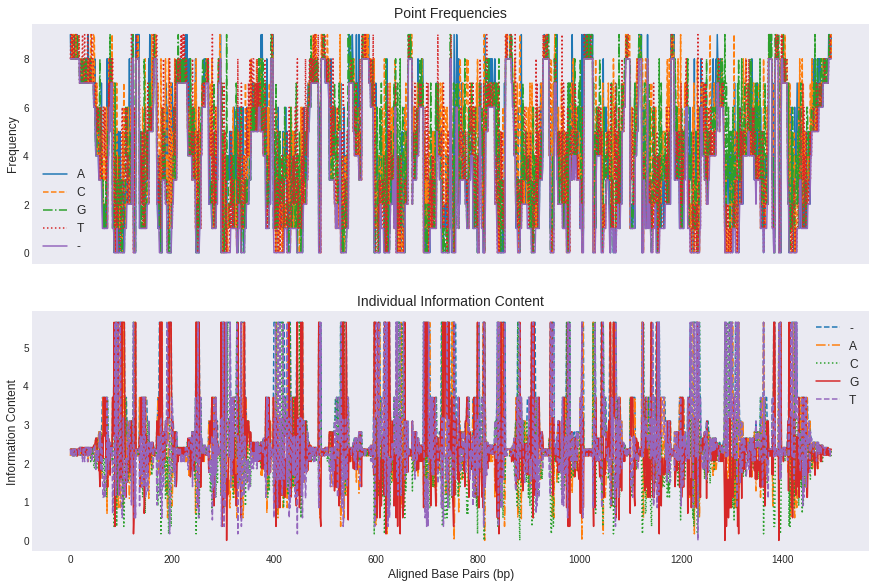

In [10]:
plt.figure(figsize=[15, 15])
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

# Frequency Counts
cts = pd.DataFrame([[let for let in str(s.seq)] for s in alignedSeqs]).apply(pd.value_counts).fillna(0).T.to_dict()
for p, n in cts['-'].items():
    for let in "ACGT":
        cts[let][p] += n

ax1 = plt.subplot('311')
for let in "ACGT-":
    plt.plot(list(cts[let].values()), label=let, ls=next(linecycler))
plt.title("Point Frequencies", fontsize=14)
plt.ylabel("Frequency", fontsize=12)
# plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# plt.xticks(range(0,len(strings[0])+1,5), rotation='vertical')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.legend(fontsize=12)

# information content
ic = pd.DataFrame(cts).apply(getInfoCntnt, 1)

plt.subplot('312')
for col in ic:
    plt.plot(ic[col], label=col, ls=next(linecycler))
plt.title("Individual Information Content", fontsize=14)
plt.ylabel("Information Content", fontsize=12)
plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# plt.xticks(range(0,len(alignedSeqs[0])+1,5), rotation='vertical')
plt.legend(ic.columns.values, fontsize=12)

plt.show()

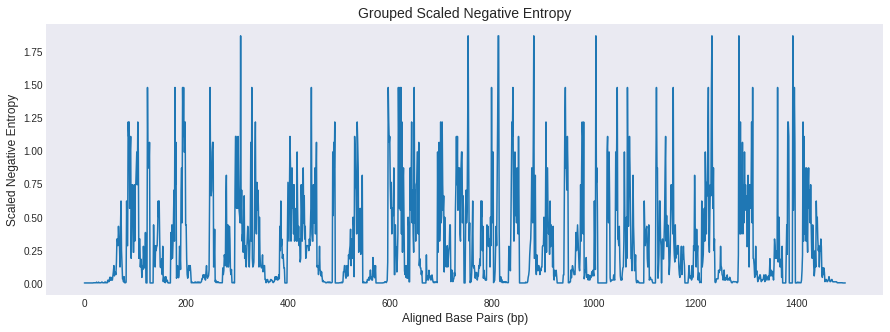

In [11]:
# negative scaled entropy
nent = pd.DataFrame(cts).apply(lambda x: -shannonEntropy(x), 1) 
nent -= nent.min()

plt.figure(figsize=[15, 5])
# plt.subplot('313')
plt.plot(nent, label="Scaled Negative Entropy")
plt.title("Grouped Scaled Negative Entropy", fontsize=14)
plt.ylabel("Scaled Negative Entropy", fontsize=12)
plt.xlabel("Aligned Base Pairs (bp)", fontsize=12)
# plt.xticks(range(0,len(alignedSeqs[0])+1,5), rotation='vertical')
# plt.legend(fontsize=12)

plt.show()

In [12]:
res = unidip.unidip(np.array(nent), is_hist=True)
print(len(res))
print(res)

RecursionError: maximum recursion depth exceeded

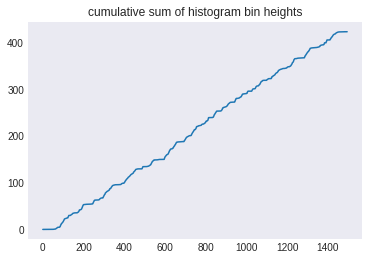

In [13]:
plt.title('cumulative sum of histogram bin heights')
plt.plot(list(range(len(nent))), np.cumsum(nent))
plt.show()

In [14]:
np.savetxt("realAlignedNent.csv", nent)